## This notebook is going to be a cleaner version of the satellite finding for the full PDR region

In [89]:
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy import units as u
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'stixgeneral'
%matplotlib inline
#matplotlib.matplotlib_fname()
#import linetools.utils as ltu
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord
import copy
from colossus.halo import profile_nfw
%config InlineBackend.figure_format = 'retina'

In [90]:
# read in the data
data_pth = '/Users/astro/Desktop/GitHub/satellite_fraction/data/'
data_file = data_pth + 's16a_massive_logmMax_11.45_z_0.25_0.47_mhalo_pdr_full.fits'

hdu1 = fits.open(data_file)
data_table = Table(hdu1[1].data)

In [91]:
# set cosmology params
import colossus
from colossus.cosmology import cosmology
params = {'flat': True , 'H0': 70.0 , 'Om0': 0.3 , 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95}
h = .7
cosmology.addCosmology('huang18',params)
cosmology.setCosmology('huang18')
from colossus.halo import mass_so

In [92]:
cat_table = Table(names = data_table.colnames)

for i in range(len(np.array(data_table['logm_max']))):
    if data_table['logm_max'][i] > 11.5 and data_table['z_best'][i] > .25 and data_table['z_best'][i] < .45:
        cat_table.add_row(data_table[i])

In [93]:
# Now to find r_halo
r_halo = mass_so.M_to_R((10**cat_table['logmh_vir'])*h , cat_table['z_best'], 'vir')/h # kpc

# Turn the physical radius into an angular size in degrees
theta_per_kpc = FlatLambdaCDM(H0=70 , Om0= 0.3).arcsec_per_kpc_proper(cat_table['z_best'])
r_halo_deg = ((r_halo*u.kpc * theta_per_kpc).to(u.deg))/u.deg

In [94]:
# put the array data into a new table
cat_table['r_halo'] = r_halo_deg
cat_table.sort('logm_max')

# bins before reversing table
mass_bins = [11.5, 11.6, 11.7, 11.8, 11.9, 12.0, 12.1, 12.2, 12.3]
cat_table.reverse() # rank order by mass

In [108]:
# actual satellite finding
import satellite_finder as sf
#mass_center_004, frac_sat_004, err_004 = sf.run_pdr_satellite(cat_table, .004, 20)
#mass_center_006, frac_sat_006, err_006 = sf.run_pdr_satellite(cat_table, .006, 20)
#mass_center_008, frac_sat_008, err_008 = sf.run_pdr_satellite(cat_table, .008, 20)
#mass_center_02, frac_sat_02, err_02 = sf.run_pdr_satellite(cat_table, .02, 20)
mass_center_04, frac_sat_04, err_04 = sf.run_pdr_satellite(cat_table, .06, mass_bins)
#mass_center_041, frac_sat_041, err_041 = sf.run_pdr_satellite(cat_table, .041, 20)

Text(0.5,1,'PDR Satellite Fraction')

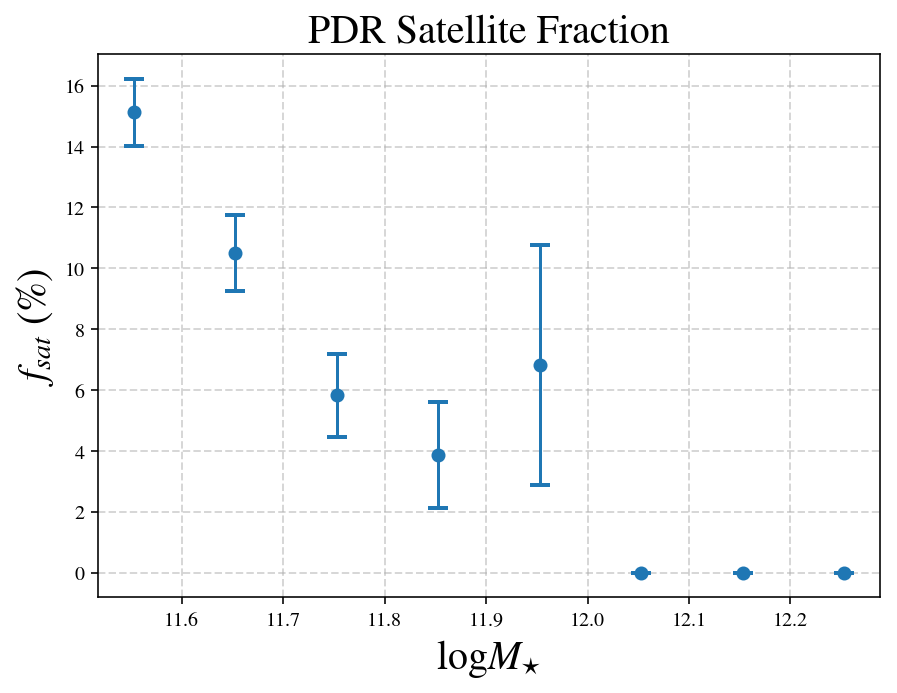

In [109]:
fig = plt.figure(figsize=(7,5))


ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

#ax1.errorbar(mass_center_004, frac_sat_004, err_004, fmt='o',capthick=2, capsize=5, label = '$dz = \pm 0.004$')
#ax1.errorbar(mass_center_006, frac_sat_006, err_006, fmt='o',capthick=2, capsize=5, label = '$dz = \pm 0.006$')
#ax1.errorbar(mass_center_008, frac_sat_008, err_008, fmt='o',capthick=2, capsize=5, label = '$dz = \pm 0.008$')
#ax1.errorbar(mass_center_02, frac_sat_02, err_02, fmt='o',capthick=2, capsize=5, label = '$dz = \pm 0.02$')
ax1.errorbar(mass_center_04, frac_sat_04, err_04, fmt='o',capthick=2, capsize=5, label = '$\Delta z = \pm 0.05$')
#ax1.errorbar(mass_center_041, frac_sat_041, err_041, fmt='o',capthick=2, capsize=5, label = '$dz = \pm 0.041$')


ax1.set_xlabel(r'$ \log M_{\star}$', fontsize=20)
ax1.set_ylabel(r'$ f_{sat}$ ($\%$)', fontsize=20)
ax1.set_title('PDR Satellite Fraction', fontsize = 20)
#plt.savefig('pdr_satellite_fraction.png', dpi = 1000)

### Now I will look at the PDR and Model Satellite Fraction side-by-side

In [110]:
model = data_pth + 'um_smdpl_model_logms_tot_11.4.fits'
hdu1 = fits.open(model)

# create astropy table of useful data
model_table = Table()
model_table['logms_tot_mod'] = hdu1[1].data['logms_tot_mod']
model_table['upid'] = hdu1[1].data['upid']
model_table.sort('logms_tot_mod')

centrals_mod = []
sats_mod = []

for i in range(27241):
    if model_table['upid'][i] == -1:
        centrals_mod.append(model_table['logms_tot_mod'][i])
    else:
        sats_mod.append(model_table['logms_tot_mod'][i])    
# range of masses
mmin = np.min(model_table['logms_tot_mod'])
mmax = np.max(model_table['logms_tot_mod'])


hist_all, edges_all = np.histogram(data_table['logm_max'], bins = mass_bins)

# from Song's satellite finding code  
hist_all_mod, edges_all_mod = np.histogram(model_table['logms_tot_mod'], bins=edges_all)
hist_cen_mod, edges_cen_mod = np.histogram(centrals_mod, bins=edges_all)
hist_sat_mod, edges_sat_mod = np.histogram(sats_mod, bins=edges_all)

mass_center_mod = np.log10((10**edges_cen_mod[1:] + 10**edges_cen_mod[:-1]) / 2)
 
frac_sat_mod = (hist_sat_mod / hist_all_mod) * 100

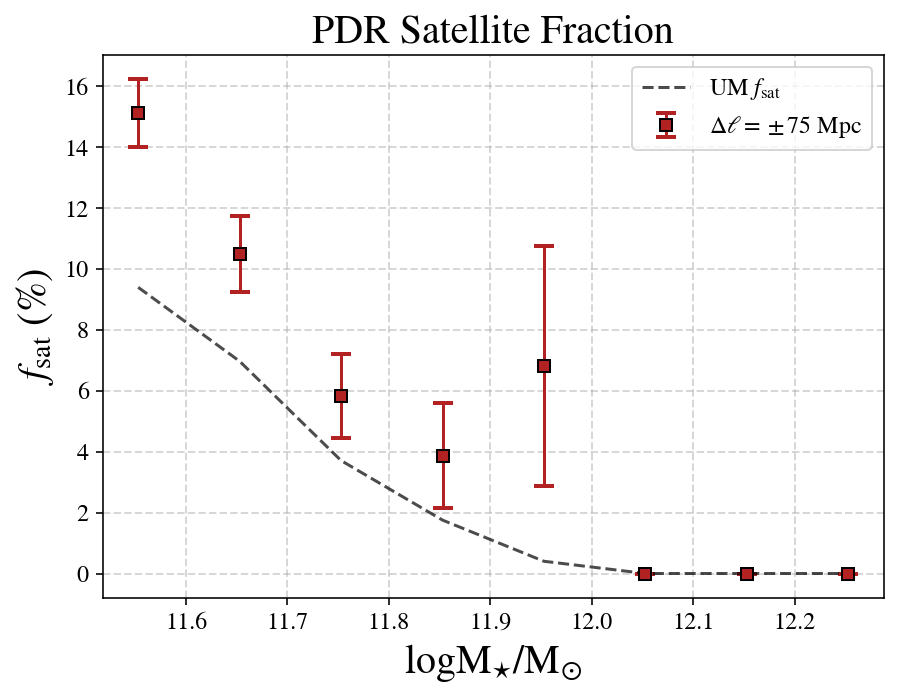

In [111]:
fig = plt.figure(figsize=(7,5))


ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

#ax1.errorbar(mass_center_004, frac_sat_004, err_004, color = 'blue', fmt='s',capthick=2, capsize=5, label = '$dz = \pm 0.004$')
#ax1.errorbar(mass_center_006, frac_sat_006, err_006, fmt='s',capthick=2, capsize=5, label = '$dz = \pm 0.006$')
#ax1.errorbar(mass_center_008, frac_sat_008, err_008, fmt='s',capthick=2, capsize=5, label = '$dz = \pm 0.008$')
#ax1.errorbar(mass_center_02, frac_sat_02, err_02, fmt='s',capthick=2, capsize=5, label = '$dz = \pm 0.02$')
ax1.errorbar(mass_center_04, frac_sat_04, err_04, color = 'firebrick',fmt='s',mec = 'k',capthick=2, capsize=5, label = '$\Delta \ell = \pm 75$ Mpc')
#ax1.errorbar(mass_center_041, frac_sat_041, err_041, fmt='s',capthick=2, capsize=5, label = '$dz = \pm 0.041$')

ax1.plot(mass_center_mod, frac_sat_mod, ls = '--', color = 'k',alpha = 0.7, label = 'UM $f_{\mathrm{sat}}$')

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)



ax1.set_xlabel(r'$ \log \mathrm{M_{\star} / M_{\odot}}$', fontsize=20)
ax1.set_ylabel(r'$f_{\mathrm{sat}}$ (%)', fontsize=20)
ax1.set_title('PDR Satellite Fraction', fontsize = 20)
ax1.legend(fontsize = 12)
#plt.savefig('pdr_satellite_fraction.png', dpi = 1000)

* For reference, I want to shade the space between the curves as a region where the fsat curves can exist.

In [82]:
Mean_logM =  [11.454280124360066, 11.578713361036991, 11.701840449447248, 11.827196417870741, 11.951702092177047]
frac_sat =  np.array([13.49764457 , 9.16328442 , 5.41699143 , 1.63398693 , 0.33557047])
frac_sat_low =  np.array([12.57567781 , 8.42428901 , 4.48395825 , 0.87241003 , 0.])
frac_sat_high =  np.array([15.32788663, 10.66708132 , 6.38379205 , 3.04518664 , 1.08401084])

err_high = frac_sat_high - frac_sat
err_low = frac_sat - frac_sat_low

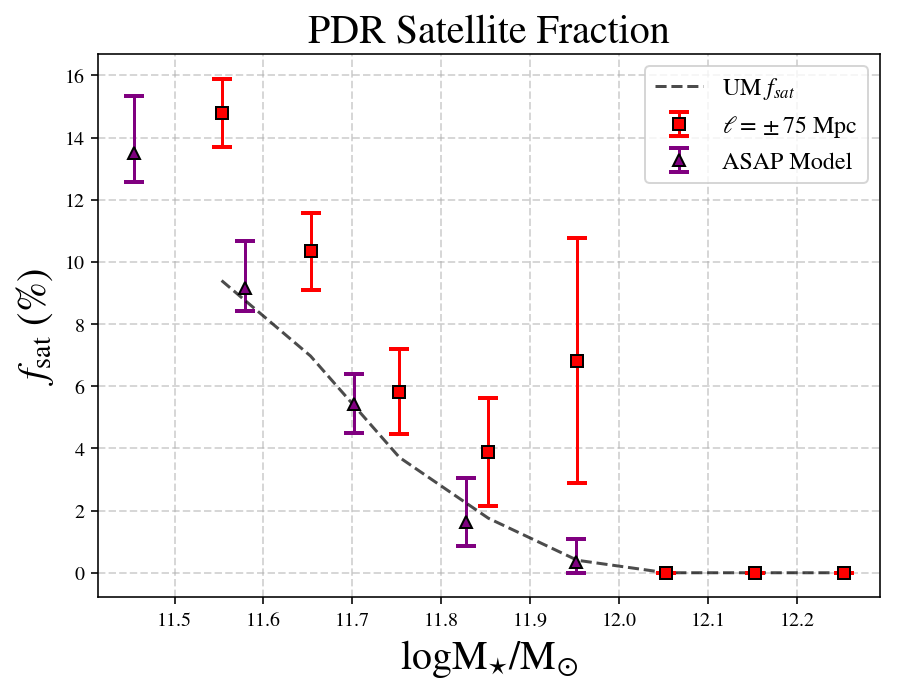

In [83]:
fig = plt.figure(figsize=(7,5))


ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

ax1.plot(mass_center_mod, frac_sat_mod, ls = '--', color = 'k',alpha = 0.7, label = 'UM $f_{sat}$')
#ax1.errorbar(mass_center_004, frac_sat_004, err_004, color = 'blue',mec = 'k', fmt='s',capthick=2, capsize=5, label = '$dz = \pm 0.004$')
ax1.errorbar(mass_center_04, frac_sat_04, err_04, color = 'red',mec = 'k',fmt='s',capthick=2, capsize=5, label = '$\ell = \pm 75$ Mpc')
#ax1.fill_between(mass_center_004[0:4], frac_sat_004[0:4], frac_sat_04[0:4], color = 'gray')

ax1.errorbar(Mean_logM, frac_sat, (err_low, err_high), color = 'purple', mec = 'k', fmt='^',capthick=2, capsize=5, label = 'ASAP Model')


ax1.set_xlabel(r'$ \log \mathrm{ M_{\star} / M_{\odot} }$', fontsize=20)
ax1.set_ylabel(r'$ f_{\mathrm{sat}}$ (%)', fontsize=20)
ax1.set_title('PDR Satellite Fraction', fontsize = 20)
ax1.legend(fontsize = 12)

plt.savefig('pdr_ASAP_satellite_fraction.eps', dpi = 1000)